In [ ]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 5.2 MB/s 
     |████████████████████████████████| 895 kB 48.0 MB/s 
     |████████████████████████████████| 3.3 MB 43.0 MB/s 
     |████████████████████████████████| 61 kB 412 kB/s 
     |████████████████████████████████| 596 kB 27.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import re
import pandas as pd

In [ ]:
df = pd.read_excel("dataset_tesis.xlsx", index_col=0)
df

,tweet,Sentimiento
0,@stellargirl I loooooooovvvvvveee my Kindle2. ...,5
1,Reading my kindle2... Love it... Lee childs i...,5
2,"Ok, first assesment of the #kindle2 ...it fuck...",5
3,@kenburbary You'll love your Kindle2. I've had...,5
4,@mikefish Fair enough. But i have the Kindle2...,5
...,...,...
639,"#TuCongresoInforma, muy buena #JuntosPorElEmpleo",3
640,#juntosporelempleo el partido de @JuntosporPer...,3
641,@Renzoiban Congresista @CarlosAnderso1 buena #...,5
642,#JuntosPorElEmpleo!!! 😂😂\nDe eso se arañan @Ru...,3


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/638M [00:00<?, ?B/s]

In [ ]:
def limpiar(tweet):
  #Elimina menciones @...
  tweet = re.sub(r'@[A-Za-z0-9]+', '', tweet)
  #Elimina el símbolo de #Hashtag
  tweet = re.sub(r'#', '', tweet)
  #Elimina RT
  tweet = re.sub(r'RT[\s]+', '', tweet)
  #Elimina los links
  tweet = re.sub(r'https?:\/\/\S+', '', tweet)
  return tweet

In [ ]:
#limpiando
df['tweet'] = df['tweet'].apply(limpiar)
df['tweet']

0       I loooooooovvvvvveee my Kindle2. Not that the...
1      Reading my kindle2...  Love it... Lee childs i...
2      Ok, first assesment of the kindle2 ...it fucki...
3       You'll love your Kindle2. I've had mine for a...
4        Fair enough. But i have the Kindle2 and I th...
                             ...                        
639       TuCongresoInforma, muy buena JuntosPorElEmpleo
640    juntosporelempleo el partido de   aliados de l...
641                 Congresista  buena juntosporelempleo
642    JuntosPorElEmpleo!!! 😂😂\nDe eso se arañan  y d...
643    Muy bien dicho,  ahora se llama JuntosPorElEmp...
Name: tweet, Length: 630, dtype: object

In [ ]:
df["tweet"][0]

' I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.'

#Análisis de sentimiento a todos los tweets

##Usando BERT

In [ ]:
def sentimiento(tweet):
  tokens = tokenizer.encode(tweet, return_tensors='pt')
  result = model(tokens)
  return int(torch.argmax(result.logits))+1

In [ ]:
##analisis de sentimiento limitado a 280 tokens (Es lo máximo que permite un Tweet --contando letras y espacios--)
df['score_bert'] = df['tweet'].apply(lambda x: sentimiento(x[:281]))

In [ ]:
def normalizar(x):
  if x == 4:
    x = 3
    return x
  if x == 2:
    x = 3
    return x
  else: return x

In [ ]:
df["score_bert"] = df["score_bert"].apply(lambda x: normalizar(x))

In [ ]:
df

,tweet,Sentimiento,score_bert
0,I loooooooovvvvvveee my Kindle2. Not that the...,5,3
1,Reading my kindle2... Love it... Lee childs i...,5,5
2,"Ok, first assesment of the kindle2 ...it fucki...",5,3
3,You'll love your Kindle2. I've had mine for a...,5,5
4,Fair enough. But i have the Kindle2 and I th...,5,3
...,...,...,...
639,"TuCongresoInforma, muy buena JuntosPorElEmpleo",3,5
640,juntosporelempleo el partido de aliados de l...,3,5
641,Congresista buena juntosporelempleo,5,5
642,JuntosPorElEmpleo!!! 😂😂\nDe eso se arañan y d...,3,1


In [ ]:
df["score_bert"].value_counts()

5    246
1    224
3    160
Name: score_bert, dtype: int64

In [ ]:
df["Sentimiento"].value_counts()

5    223
3    207
1    200
Name: Sentimiento, dtype: int64

##TextBlob

In [ ]:
from textblob import TextBlob
df['score_textBlob'] = df['tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['score_textBlob'] = pd.cut(df['score_textBlob'],bins=3,labels=[1, 3, 5])
df

,tweet,Sentimiento,score_bert,score_textBlob
0,I loooooooovvvvvveee my Kindle2. Not that the...,5,3,5
1,Reading my kindle2... Love it... Lee childs i...,5,5,5
2,"Ok, first assesment of the kindle2 ...it fucki...",5,3,3
3,You'll love your Kindle2. I've had mine for a...,5,5,3
4,Fair enough. But i have the Kindle2 and I th...,5,3,5
...,...,...,...,...
639,"TuCongresoInforma, muy buena JuntosPorElEmpleo",3,5,3
640,juntosporelempleo el partido de aliados de l...,3,5,3
641,Congresista buena juntosporelempleo,5,5,3
642,JuntosPorElEmpleo!!! 😂😂\nDe eso se arañan y d...,3,1,3


##Usando vader de NLTK

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
vader = SentimentIntensityAnalyzer()
df['score_vader'] = df['tweet'].apply(lambda x: vader.polarity_scores(x)['compound'])
df['score_vader'] = pd.cut(df['score_vader'], bins=3, labels=[1, 3, 5])
df

,tweet,Sentimiento,score_bert,score_textBlob,score_vader
0,I loooooooovvvvvveee my Kindle2. Not that the...,5,3,5,5
1,Reading my kindle2... Love it... Lee childs i...,5,5,5,5
2,"Ok, first assesment of the kindle2 ...it fucki...",5,3,3,5
3,You'll love your Kindle2. I've had mine for a...,5,5,3,5
4,Fair enough. But i have the Kindle2 and I th...,5,3,5,5
...,...,...,...,...,...
639,"TuCongresoInforma, muy buena JuntosPorElEmpleo",3,5,3,3
640,juntosporelempleo el partido de aliados de l...,3,5,3,3
641,Congresista buena juntosporelempleo,5,5,3,3
642,JuntosPorElEmpleo!!! 😂😂\nDe eso se arañan y d...,3,1,3,3


##Matriz de confusión

###BERT

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np 

In [ ]:
#para score_bert
cm = confusion_matrix(df["score_bert"],df["Sentimiento"],labels=[1, 3, 5])
print(cm)

[[140  51  33]
 [ 42  63  55]
 [ 18  93 135]]


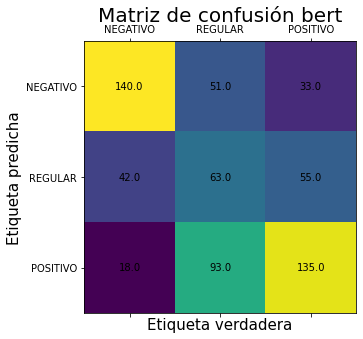

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.matshow(cm)
plt.title("Matriz de confusión bert", fontsize=20)
plt.ylabel("Etiqueta predicha", fontsize=15)
plt.xlabel("Etiqueta verdadera", fontsize=15)
alpha = ['NEGATIVO', 'REGULAR', 'POSITIVO']
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)
for (i,j), z in np.ndenumerate(cm):
  ax.text(j,i, '{:0.1f}'.format(z), ha='center', va='center')

In [ ]:
##precision
from sklearn.metrics import precision_score
precision_score(df["Sentimiento"], df["score_bert"], average='macro')

0.5225101626016261

In [ ]:
##recall
from sklearn.metrics import recall_score
recall_score(df["Sentimiento"], df["score_bert"], average='macro')

0.5365763306687463

In [ ]:
##F1-score
from sklearn.metrics import f1_score
f1_score(df["Sentimiento"], df["score_bert"], average='macro')

0.5264648576414768

###Textblob

In [ ]:
cm = confusion_matrix(df["score_textBlob"],df["Sentimiento"],labels=[1, 3, 5])
print(cm)

[[ 47   4   3]
 [131 188 113]
 [ 22  15 107]]


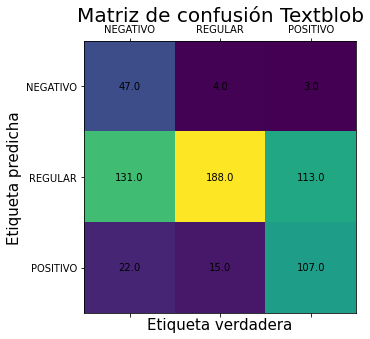

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.matshow(cm)
plt.title("Matriz de confusión Textblob", fontsize=20)
plt.ylabel("Etiqueta predicha", fontsize=15)
plt.xlabel("Etiqueta verdadera", fontsize=15)
alpha = ['NEGATIVO', 'REGULAR', 'POSITIVO']
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)
for (i,j), z in np.ndenumerate(cm):
  ax.text(j,i, '{:0.1f}'.format(z), ha='center', va='center')

In [ ]:
##precision
from sklearn.metrics import precision_score
precision_score(df["Sentimiento"], df["score_textBlob"], average='macro')

0.6828703703703703

In [ ]:
##recall
from sklearn.metrics import recall_score
recall_score(df["Sentimiento"], df["score_textBlob"], average='macro')

0.5410110627297213

In [ ]:
##F1-score
from sklearn.metrics import f1_score
f1_score(df["Sentimiento"], df["score_textBlob"], average='macro')

0.5138681375027557

###VADER

In [ ]:
cm = confusion_matrix(df["score_vader"],df["Sentimiento"],labels=[1, 3, 5])
print(cm)

[[103   9  13]
 [ 69 170  67]
 [ 28  28 143]]


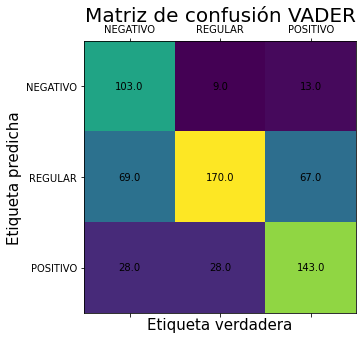

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.matshow(cm)
plt.title("Matriz de confusión VADER", fontsize=20)
plt.ylabel("Etiqueta predicha", fontsize=15)
plt.xlabel("Etiqueta verdadera", fontsize=15)
alpha = ['NEGATIVO', 'REGULAR', 'POSITIVO']
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)
for (i,j), z in np.ndenumerate(cm):
  ax.text(j,i, '{:0.1f}'.format(z), ha='center', va='center')

In [ ]:
##precision
from sklearn.metrics import precision_score
precision_score(df["Sentimiento"], df["score_vader"], average='macro')

0.6993828401265588

In [ ]:
##recall
from sklearn.metrics import recall_score
recall_score(df["Sentimiento"], df["score_vader"], average='macro')

0.659170548009503

In [ ]:
##F1-score
from sklearn.metrics import f1_score
f1_score(df["Sentimiento"], df["score_vader"], average='macro')

0.6581131011728834

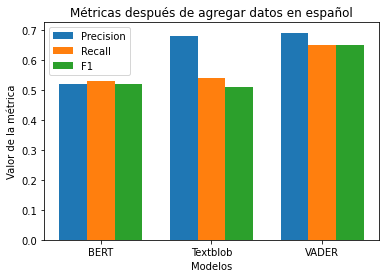

In [ ]:
serie_1 = [0.52, 0.68, 0.69]
serie_2 = [0.53, 0.54, 0.65]
serie_3 = [0.52, 0.51, 0.65]

numero_de_grupos = len(serie_1)
indice_barras = np.arange(numero_de_grupos)
ancho_barras =0.25
 
plt.bar(indice_barras, serie_1, width=ancho_barras, label='Precision')
plt.bar(indice_barras + ancho_barras, serie_2, width=ancho_barras, label='Recall')
plt.bar(indice_barras + ancho_barras + ancho_barras, serie_3, width=ancho_barras, label='F1')
plt.legend(loc='best')
plt.xticks(indice_barras + ancho_barras, ('BERT', 'Textblob', 'VADER'))
 
plt.ylabel('Valor de la métrica')
plt.xlabel('Modelos')
plt.title('Métricas después de agregar datos en español')
 
plt.show()